# Import packages and load Data Set

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 'skus' table
skus = pd.read_csv('Jd_com_data/JD_sku_data.csv')
# 'users' table
users = pd.read_csv('Jd_com_data/JD_user_data.csv')
# 'clicks' table
clicks = pd.read_csv('Jd_com_data/JD_click_data.csv')
# 'orders' table
orders = pd.read_csv('Jd_com_data/JD_order_data.csv')
# 'delivery' table
delivery = pd.read_csv('Jd_com_data/JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('Jd_com_data/JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('Jd_com_data/JD_network_data.csv')

## orders

In [4]:
orders.shape

(549989, 17)

In [5]:
orders.head()

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
0,d0cf5cc6db,0abe9ef2ce,581d5b54c1,2018-03-01,2018-03-01 17:14:25.0,1,2,-,89.0,79.0,0.0,10.0,0.0,0.0,0,4,28
1,7444318d01,33a9e56257,067b673f2b,2018-03-01,2018-03-01 11:10:40.0,1,1,2,99.9,53.9,5.0,41.0,0.0,0.0,0,28,28
2,f973b01694,4ea3cf408f,623d0a582a,2018-03-01,2018-03-01 09:13:26.0,1,1,2,78.0,58.5,19.5,0.0,0.0,0.0,0,28,28
3,8c1cec8d4b,b87cb736cb,fc5289b139,2018-03-01,2018-03-01 21:29:50.0,1,1,2,61.0,35.0,0.0,26.0,0.0,0.0,0,4,28
4,d43a33c38a,4829223b6f,623d0a582a,2018-03-01,2018-03-01 19:13:37.0,1,1,1,78.0,53.0,19.0,0.0,0.0,6.0,0,3,16


## 只考虑 orders['quantity']=1 且不是 gift

In [6]:
# only consider orders whose quantity equal to 1 and are not gift

orders1 = orders[(orders['quantity']==1) & (orders['gift_item']==0)].copy()

这样的过滤还不够

比如一个user买了2个sku1和1个sku2,目前还是留下了他sku2的order record,但是这个customer的全部记录都是应该被删除的

In [7]:
# 找出购买过多个相同sku的user
user_orderMulti = orders[orders['quantity']>1]['user_ID'].values


* 如果同一个user有很多order，那么大部分order都是gift

### 从小商店user入手

In [8]:
# enterprise user
enterpriseUser = users[users["user_level"]==10]['user_ID']

* 小商店user的order量占总量的1.18%

**以order量最大的商店user为例**

In [9]:
eg = orders1[orders1['user_ID']=='2d25359f9b'].copy()

In [10]:
eg['sku_ID'].value_counts()

38d636d2a6    116
81e57cbc50    106
c56544784c     91
8dc4a01dec     66
7f947c0055     54
589c2b865b     47
4b65db43ac     42
915cd3c4c0     30
Name: sku_ID, dtype: int64

**Conclusion**

* user_ID = "2d25359f9b" 的全部552个order只来自8个sku_ID
* 8个sku_ID只占sku_ID总量的0.09%， 但这8个sku_ID的order量占总量的7.58%
* 这8个都是 type=1（京东自营）的，事实上超过53%的order都是买的京东自营，虽然京东自营的sku_ID只占3.6%

有user会同时买2个sku1和1个sku2，所以要将这种user的所有order剔除

In [11]:
orders1 = orders1[~orders1['user_ID'].isin(user_orderMulti)]

In [12]:
orders1.shape

(384186, 17)

### 以这8个sku为set进行分析

In [13]:
skuSet = eg['sku_ID'].unique()

In [14]:
skuSet

array(['81e57cbc50', '38d636d2a6', '589c2b865b', '8dc4a01dec',
       '7f947c0055', 'c56544784c', '4b65db43ac', '915cd3c4c0'],
      dtype=object)

**分析clicks数据，看这8个sku是否经常被比较**

In [15]:
clicks.shape

(20214515, 4)

In [16]:
clicks.head()

,sku_ID,user_ID,request_time,channel
0,a234e08c57,4c3d6d10c2,2018-03-01 23:57:53,wechat
1,6449e1fd87,-,2018-03-01 16:13:48,wechat
2,09b70fcd83,2791ec4485,2018-03-01 22:10:51,wechat
3,09b70fcd83,eb0718c1c9,2018-03-01 16:34:08,wechat
4,09b70fcd83,59f84cf342,2018-03-01 22:20:35,wechat


**只看这8个sku的click记录，且排除orders['quantity']>1的user (所以只留下orders['quantity']=1或没买这8个sku的user)**

In [17]:
clk = clicks[(clicks['sku_ID'].isin(skuSet)) & ~(clicks['user_ID'].isin(user_orderMulti))].copy()
clk.reset_index(inplace=True,drop=True)

In [18]:
clk['request_time'] = pd.to_datetime(clk['request_time'])
clk = clk.groupby('user_ID',group_keys=False).apply(lambda x: x.sort_values('request_time'))
clk.reset_index(inplace=True,drop=True)

In [19]:
clk.shape

(1261134, 4)

In [24]:
# # clk.to_csv("clk.csv")
# clk = pd.read_csv("clk.csv",index_col=0)
# clk['request_time'] = pd.to_datetime(clk['request_time'])

**删除user_ID = '-'的记录**

In [20]:
clk = clk[~(clk['user_ID']=='-')]
clk.reset_index(inplace=True,drop=True)

In [21]:
clk.shape

(1167826, 4)

In [22]:
clk['sku_ID'].value_counts()

8dc4a01dec    337972
38d636d2a6    207839
81e57cbc50    144800
7f947c0055    131389
589c2b865b    122705
4b65db43ac    103811
c56544784c     66363
915cd3c4c0     52947
Name: sku_ID, dtype: int64

**标记普通客户及其订单**

In [24]:
normalCustomers = users[~(users['user_level']==10)]['user_ID'].values
orderNormal = orders1[orders1['user_ID'].isin(normalCustomers)].copy()

In [25]:
orderNormal.shape

(382955, 17)

In [26]:
len(orderNormal['user_ID'].unique())

348246

In [27]:
len(orderNormal['order_ID'].unique())

364613

* 364613个order_ID由348246个user_ID完成，所以几乎每个普通user在3月只买了一次

In [28]:
orderNormal['order_time'] = pd.to_datetime(orderNormal['order_time'])

In [29]:
orderNormal.head()

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
0,d0cf5cc6db,0abe9ef2ce,581d5b54c1,2018-03-01,2018-03-01 17:14:25,1,2,-,89.0,79.0,0.0,10.0,0.0,0.0,0,4,28
1,7444318d01,33a9e56257,067b673f2b,2018-03-01,2018-03-01 11:10:40,1,1,2,99.9,53.9,5.0,41.0,0.0,0.0,0,28,28
2,f973b01694,4ea3cf408f,623d0a582a,2018-03-01,2018-03-01 09:13:26,1,1,2,78.0,58.5,19.5,0.0,0.0,0.0,0,28,28
3,8c1cec8d4b,b87cb736cb,fc5289b139,2018-03-01,2018-03-01 21:29:50,1,1,2,61.0,35.0,0.0,26.0,0.0,0.0,0,4,28
4,d43a33c38a,4829223b6f,623d0a582a,2018-03-01,2018-03-01 19:13:37,1,1,1,78.0,53.0,19.0,0.0,0.0,6.0,0,3,16


In [30]:
# delta = orderNormal.groupby('user_ID').apply(lambda x: x['order_time'].max()-x['order_time'].min())

In [54]:
# delta

user_ID
000089d6a6   0 days
0000babd1f   0 days
0000bc018b   0 days
0000d0e5ab   0 days
0000dce472   0 days
              ...  
ffff03373a   0 days
ffff0b5ecd   0 days
ffff38690b   0 days
ffffb20ef7   0 days
ffffc45330   0 days
Length: 348246, dtype: timedelta64[ns]

In [63]:
# delta[delta>dt.timedelta(0)]

user_ID
000517abd3   29 days 03:26:23
00082ccb98    0 days 00:32:23
001282c65e    6 days 02:58:27
0013804aa0    7 days 10:58:59
00182fd9ea   13 days 06:23:38
                   ...       
ffea8dfcda    3 days 01:06:31
ffeee86eec    1 days 18:59:17
fff7767f6a    2 days 12:15:58
fffe8dd91f    5 days 06:05:55
fffee3a17c    0 days 00:03:30
Length: 11783, dtype: timedelta64[ns]

In [66]:
# longD = delta[delta>dt.timedelta(0)]

In [70]:
# longD.describe()

count                     11783
mean     5 days 15:15:14.047356
std      7 days 05:40:26.912726
min             0 days 00:00:09
25%             0 days 01:01:15
50%             2 days 04:39:38
75%      8 days 19:14:35.500000
max            30 days 09:55:18
dtype: object

**普通user的click记录**

In [31]:
clkNormal = clk[clk['user_ID'].isin(normalCustomers)].copy()

In [32]:
click_record = []
allusers = clkNormal['user_ID'].unique()

for user in allusers:
    clickSet = clkNormal[clkNormal['user_ID']==user]['sku_ID'].unique()
    num = len(clickSet)
    click_record.append((user,num,clickSet))

In [33]:
df_click = pd.DataFrame(click_record,columns=['user_ID','clickNum','clickSku'])
df_click['clickSet'] = df_click['clickSku'].apply(np.sort).apply(str)

In [34]:
df_click

,user_ID,clickNum,clickSku,clickSet
0,0000dce472,1,[589c2b865b],['589c2b865b']
1,0001aa7059,1,[8dc4a01dec],['8dc4a01dec']
2,00026e5698,1,[589c2b865b],['589c2b865b']
3,000479b177,1,[7f947c0055],['7f947c0055']
4,00047c5b47,1,[8dc4a01dec],['8dc4a01dec']
5,000517abd3,1,[8dc4a01dec],['8dc4a01dec']
6,0005501fd6,1,[915cd3c4c0],['915cd3c4c0']
7,000593d7fd,1,[589c2b865b],['589c2b865b']
8,0006cd5d1f,1,[81e57cbc50],['81e57cbc50']
9,0009bb7aea,2,"[589c2b865b, 4b65db43ac]",['4b65db43ac' '589c2b865b']


In [93]:
# df_click.to_csv('df_click.csv')

In [35]:
clickSet = df_click.groupby('clickSet',group_keys=False).count()

In [36]:
purchase = orderNormal[['user_ID','sku_ID']].copy()
purchase = purchase[purchase['sku_ID'].isin(skuSet)]
purchase.reset_index(inplace=True,drop=True)
purchase.drop_duplicates(inplace = True)

In [37]:
buy = {}
for index, row in purchase.iterrows():
    if row['user_ID'] in buy.keys():
        buy[row['user_ID']].append(row['sku_ID'])
    else:
        buy[row['user_ID']] = [row['sku_ID']]

In [38]:
purchase = pd.DataFrame({'user_ID':list(buy.keys()),'purchaseSku':list(buy.values())})

In [39]:
purchase['purchaseNum'] = purchase['purchaseSku'].apply(len)

**查看购买user_level分布**

In [40]:
purchase_dist = pd.merge(purchase,users,left_on='user_ID',right_on='user_ID',how='left')

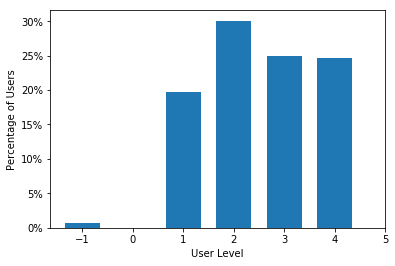

In [41]:
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    return str(int(100 * y)) + '%'

bin_edges = np.arange(-1, 6, 1)
plt.hist(purchase_dist['user_level'],bins = bin_edges, rwidth = 0.7, weights= [1./ len(purchase_dist)] * len(purchase_dist), align='left')

formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlim(right=5)

plt.xlabel('User Level')
plt.ylabel('Percentage of Users')

plt.show()

In [43]:
productSet = pd.merge(df_click,purchase,left_on='user_ID',right_on='user_ID',how='outer')

In [44]:
print("user number")
print('一共有   ', len(productSet))
print("没买的   ", len(productSet[productSet['purchaseNum'].isna()]))
print("买了1个的", len(productSet[productSet['purchaseNum']==1]))
print("买了2个的", len(productSet[productSet['purchaseNum']==2]))
print("买了3个的", len(productSet[productSet['purchaseNum']==3]))

user number
一共有    83376
没买的    55721
买了1个的 27331
买了2个的 322
买了3个的 2


**整理click和purchase数据**

In [171]:
productSet

,user_ID,clickNum,clickSku,clickSet,purchaseSku,purchaseNum
0,0000dce472,1.0,[589c2b865b],['589c2b865b'],NaN,NaN
1,0001aa7059,1.0,[8dc4a01dec],['8dc4a01dec'],NaN,NaN
2,00026e5698,1.0,[589c2b865b],['589c2b865b'],NaN,NaN
3,000479b177,1.0,[7f947c0055],['7f947c0055'],[7f947c0055],1.0
4,00047c5b47,1.0,[8dc4a01dec],['8dc4a01dec'],[8dc4a01dec],1.0
...,...,...,...,...,...,...
83371,d7e51b5a69,NaN,NaN,NaN,[915cd3c4c0],1.0
83372,2872e7352f,NaN,NaN,NaN,[915cd3c4c0],1.0
83373,7c5be90738,NaN,NaN,NaN,[c56544784c],1.0
83374,f8c7c795f3,NaN,NaN,NaN,[81e57cbc50],1.0


In [45]:
pSet = productSet.copy()

In [46]:
pSet['clickSku'] = np.where(productSet['clickSku'].isna(),productSet['purchaseSku'],productSet['clickSku'])

In [47]:
def func(x):
    if type(x['purchaseSku'])==list:
        x['new'] = x['clickSku']
        for i in x['purchaseSku']:
            if i not in x['clickSku']:
                x['new'] = np.append(x['new'],i)
    else:
        x['new'] = x['clickSku']
    return x

In [48]:
product =  pSet.apply(func,axis=1)

In [49]:
product['newNum'] = product['new'].apply(len)

In [50]:
product['clickNum'] = product['newNum']
product['clickSku'] = product['new']

In [54]:
product.drop(['new','newNum'],axis=1,inplace=True)

In [55]:
product['clickSet'] = product['clickSku'].apply(np.sort).apply(str)
product['purchaseNum'] = product['purchaseNum'].fillna(0)
product['purchaseSet'] = product[['purchaseNum','purchaseSku']].apply(lambda x: np.sort(x['purchaseSku']) 
                                             if x['purchaseNum']>1 else x['purchaseSku'],axis=1).apply(str)

In [56]:
product

,user_ID,clickNum,clickSku,clickSet,purchaseSku,purchaseNum,purchaseSet
0,0000dce472,1,[589c2b865b],['589c2b865b'],NaN,0.0,nan
1,0001aa7059,1,[8dc4a01dec],['8dc4a01dec'],NaN,0.0,nan
2,00026e5698,1,[589c2b865b],['589c2b865b'],NaN,0.0,nan
3,000479b177,1,[7f947c0055],['7f947c0055'],[7f947c0055],1.0,['7f947c0055']
4,00047c5b47,1,[8dc4a01dec],['8dc4a01dec'],[8dc4a01dec],1.0,['8dc4a01dec']
5,000517abd3,1,[8dc4a01dec],['8dc4a01dec'],NaN,0.0,nan
6,0005501fd6,1,[915cd3c4c0],['915cd3c4c0'],[915cd3c4c0],1.0,['915cd3c4c0']
7,000593d7fd,1,[589c2b865b],['589c2b865b'],NaN,0.0,nan
8,0006cd5d1f,1,[81e57cbc50],['81e57cbc50'],NaN,0.0,nan
9,0009bb7aea,2,"[589c2b865b, 4b65db43ac]",['4b65db43ac' '589c2b865b'],NaN,0.0,nan


In [407]:
# 重要结果数据
product.to_csv("productSet.csv")

**查看clickSet和purchaseSet的情况**

In [57]:
grouby_clickSet = product.groupby('clickSet').count()

In [58]:
grouby_clickSet

,user_ID,clickNum,clickSku,purchaseSku,purchaseNum,purchaseSet
clickSet,,,,,,
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n '8dc4a01dec' '915cd3c4c0' 'c56544784c'],6,6,6,1,6,6
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n '8dc4a01dec' '915cd3c4c0'],2,2,2,0,2,2
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n '8dc4a01dec' 'c56544784c'],6,6,6,1,6,6
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n '8dc4a01dec'],8,8,8,2,8,8
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n '915cd3c4c0' 'c56544784c'],1,1,1,1,1,1
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n '915cd3c4c0'],1,1,1,0,1,1
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '81e57cbc50'\n 'c56544784c'],3,3,3,1,3,3
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '8dc4a01dec'\n '915cd3c4c0' 'c56544784c'],2,2,2,2,2,2
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c0055' '8dc4a01dec'\n '915cd3c4c0'],7,7,7,2,7,7


In [59]:
2**8-1

255

255种组合出现了239种

In [60]:
groupby_purchaseSet = product.groupby('purchaseSet').count()

In [61]:
groupby_purchaseSet

,user_ID,clickNum,clickSku,clickSet,purchaseSku,purchaseNum
purchaseSet,,,,,,
['38d636d2a6' '4b65db43ac'],7,7,7,7,7,7
['38d636d2a6' '589c2b865b'],7,7,7,7,7,7
['38d636d2a6' '7f947c0055' '8dc4a01dec'],1,1,1,1,1,1
['38d636d2a6' '7f947c0055'],5,5,5,5,5,5
['38d636d2a6' '81e57cbc50'],14,14,14,14,14,14
['38d636d2a6' '8dc4a01dec'],49,49,49,49,49,49
['38d636d2a6' '915cd3c4c0'],3,3,3,3,3,3
['38d636d2a6' 'c56544784c'],8,8,8,8,8,8
['38d636d2a6'],5665,5665,5665,5665,5665,5665


In [62]:
groupby_purchaseSet.shape

(37, 6)

256种组合出现了37种

**组合click和purchase看**

In [63]:
combination = product.groupby(['clickSet','purchaseSet']).count()

In [64]:
combination['Number'] = combination['user_ID']

In [65]:
combination = combination[['Number']]

In [66]:
combination

Number
clickSet                                           purchaseSet                        
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['589c2b865b']                    1
                                                   nan                               5
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... nan                               2
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['8dc4a01dec']                    1
                                                   nan                               5
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['4b65db43ac']                    1
                                                   ['8dc4a01dec']                    1
                                                   nan                               6
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['915cd3c4c0']                    1
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... nan                               1
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['c56544784c']                    1
                                                   nan                               2
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['8dc4a01dec']                    2
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['4b65db43ac']                    1
                                                   ['589c2b865b']                    1
                                                   nan                               5
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['4b65db43ac']                    1
                                                   ['8dc4a01dec']                    1
                                                   nan                               3
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['38d636d2a6' '8dc4a01dec']       1
                                                   ['4b65db43ac']                    2
                                                   ['589c2b865b']                    1
                                                   ['8dc4a01dec']                    3
                                                   nan                              19
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... nan                               1
['38d636d2a6' '4b65db43ac' '589c2b865b' '7f947c... ['4b65db43ac']                    1
                                                   ['589c2b865b']                    1
                                                   nan                               5
['38d636d2a6' '4b65db43ac' '589c2b865b' '81e57c... nan                               2
['38d636d2a6' '4b65db43ac' '589c2b865b' '81e57c... ['589c2b865b']                    1
...                                                                                ...
['81e57cbc50' '915cd3c4c0' 'c56544784c']           nan                              39
['81e57cbc50' '915cd3c4c0']                        ['81e57cbc50']                   21
                                                   ['915cd3c4c0']                   19
                                                   nan                             131
['81e57cbc50' 'c56544784c']                        ['81e57cbc50' 'c56544784c']      18
                                                   ['81e57cbc50']                  294
                                                   ['c56544784c']                  369
                                                   nan                            1441
['81e57cbc50']                                     ['81e57cbc50']                 2222
                                                   nan                            6813
['8dc4a01dec' '915cd3c4c0' 'c56544784c']           ['8dc4a01dec']                    1
                                                   ['c56544784c']                    1
                                                   nan                              11
['8dc4a01dec' '915cd3c4c0']                        ['8dc4a01dec' '915cd3c4c0']

In [418]:
# product[product['purchaseNum']>1][['clickNum','purchaseNum']]

,clickNum,purchaseNum
215,4,2.0
408,2,2.0
508,5,2.0
737,2,2.0
1131,2,2.0
...,...,...
82515,2,2.0
82649,2,2.0
82761,2,2.0
83115,2,2.0


In [419]:
# product[product['purchaseNum']>2][['clickNum','purchaseNum']]

,clickNum,purchaseNum
55222,3,3.0
65806,3,3.0
